Import python libraries required for the script

In [1]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.svm import SVC

import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from rfpimp import *
from xgboost import XGBClassifier
from xgboost import plot_importance


In [2]:
# Initialize our classifiers
ADA = AdaBoostClassifier(n_estimators=100, random_state=7)
BNB = BernoulliNB()
GNB = GaussianNB()
KNN = KNeighborsClassifier(n_neighbors=5, n_jobs=3)
LSVC = LinearSVC(max_iter=3000, tol=0.001, random_state=7)
MNB = MultinomialNB()
NSVC = NuSVC(nu=0.5, gamma='scale', random_state=7) # need to study about good value for nu
SVC = SVC(gamma='scale', random_state=7)

BAG = BaggingClassifier(n_estimators=100, n_jobs=3, random_state=7) #   needs increase in n_estimators --> warm_start=True,
GBC = GradientBoostingClassifier(n_estimators=100, warm_start=True, random_state=7)
LR = LogisticRegression(solver='lbfgs', multi_class='multinomial', warm_start=True, n_jobs=3)
MLP1 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(96, 48, 24, 12, 6, 3), random_state=7, warm_start=True)
MLP2 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(12, 6, 3), random_state=7, warm_start=True)
RFC = RandomForestClassifier(n_estimators=100, n_jobs=3, random_state=7) # needs increase in n_estimators --> warm_start=True,
SGD = SGDClassifier(max_iter=1000, tol=0.001, n_jobs=3, warm_start=True, random_state=7)
XTree = ExtraTreesClassifier(n_estimators=100, n_jobs=3, random_state=7) # needs increase in n_estimators --> warm_start=True,

# Vote = VotingClassifier()

XGB = XGBClassifier(max_depth=5, n_estimators=300)


Read the CSV files

In [3]:
df = pd.read_csv('VMI_Data_BP1_V02_AK6_mod02.csv')
print(df.columns)

Index(['CUT_LENGTH', 'CONV_WAIT_TIME', 'LFT_SPLICE_LENGTH',
       'MID_SPLICE_LENGTH', 'RHT_SPLICE_LENGTH', 'SPLICE_OK', 'BP1_S8_L',
       'BP1_S7_L', 'BP1_S6_L', 'BP1_S5_L', 'BP1_S4_L', 'BP1_S3_L', 'BP1_S2_L',
       'BP1_S1_ML', 'BP1_S1_MR', 'BP1_S2_R', 'BP1_S3_R', 'BP1_S4_R',
       'BP1_S5_R', 'BP1_S6_R', 'BP1_S7_R', 'BP1_S8_R', 'PART_LENGTH',
       'LFT_SPLICE_DELTA', 'LFT_SPLICE_PREV', 'LFT_SPLICE_MA5',
       'LFT_SPLICE_MA10', 'LFT_SPLICE_MA20', 'LFT_SPLICE_MA50',
       'LFT_SPLICE_SLOPE5', 'LFT_SPLICE_SLOPE10', 'LFT_SPLICE_SLOPE20',
       'LFT_SPLICE_SLOPE50', 'MID_SPLICE_DELTA', 'MID_SPLICE_PREV',
       'MID_SPLICE_MA5', 'MID_SPLICE_MA10', 'MID_SPLICE_MA20',
       'MID_SPLICE_MA50', 'MID_SPLICE_SLOPE5', 'MID_SPLICE_SLOPE10',
       'MID_SPLICE_SLOPE20', 'MID_SPLICE_SLOPE50', 'RHT_SPLICE_DELTA',
       'RHT_SPLICE_PREV', 'RHT_SPLICE_MA5', 'RHT_SPLICE_MA10',
       'RHT_SPLICE_MA20', 'RHT_SPLICE_MA50', 'RHT_SPLICE_SLOPE5',
       'RHT_SPLICE_SLOPE10', 'RHT_SPLICE_SLOPE20

In [4]:
df = df.drop(['LFT_SPLICE_LENGTH', 'MID_SPLICE_LENGTH', 'RHT_SPLICE_LENGTH', 'SPLICE_OK', 'LFT_SPLICE_GRADE', 
              'MID_SPLICE_GRADE', 'RHT_SPLICE_GRADE', 'LFT_SPLICE_DELTA', 'MID_SPLICE_DELTA', 'RHT_SPLICE_DELTA'
#               'LFT_SPLICE_MA5', 'LFT_SPLICE_MA10', 'LFT_SPLICE_MA20', 'LFT_SPLICE_MA50', 
#               'LFT_SPLICE_SLOPE5', 'LFT_SPLICE_SLOPE10', 'LFT_SPLICE_SLOPE20', 'LFT_SPLICE_SLOPE50',
#               , 'MID_SPLICE_MA5', 'MID_SPLICE_MA10', 'MID_SPLICE_MA20',
#               'MID_SPLICE_MA50', 'MID_SPLICE_SLOPE5', 'MID_SPLICE_SLOPE10', 'MID_SPLICE_SLOPE20',
#               'MID_SPLICE_SLOPE50',  'RHT_SPLICE_MA5', 'RHT_SPLICE_MA10', 
#               'RHT_SPLICE_MA20', 'RHT_SPLICE_MA50', 'RHT_SPLICE_SLOPE5', 'RHT_SPLICE_SLOPE10',
#               'RHT_SPLICE_SLOPE20', 'RHT_SPLICE_SLOPE50'
             ], axis=1)

print(df.columns)

for col in df.columns:
    if len(df[col].unique()) == 1:
        df = df.drop(col,inplace=True,axis=1)
        
print(df.columns)
# df['SPLICE_GRADE'].head

Index(['CUT_LENGTH', 'CONV_WAIT_TIME', 'BP1_S8_L', 'BP1_S7_L', 'BP1_S6_L',
       'BP1_S5_L', 'BP1_S4_L', 'BP1_S3_L', 'BP1_S2_L', 'BP1_S1_ML',
       'BP1_S1_MR', 'BP1_S2_R', 'BP1_S3_R', 'BP1_S4_R', 'BP1_S5_R', 'BP1_S6_R',
       'BP1_S7_R', 'BP1_S8_R', 'PART_LENGTH', 'LFT_SPLICE_PREV',
       'LFT_SPLICE_MA5', 'LFT_SPLICE_MA10', 'LFT_SPLICE_MA20',
       'LFT_SPLICE_MA50', 'LFT_SPLICE_SLOPE5', 'LFT_SPLICE_SLOPE10',
       'LFT_SPLICE_SLOPE20', 'LFT_SPLICE_SLOPE50', 'MID_SPLICE_PREV',
       'MID_SPLICE_MA5', 'MID_SPLICE_MA10', 'MID_SPLICE_MA20',
       'MID_SPLICE_MA50', 'MID_SPLICE_SLOPE5', 'MID_SPLICE_SLOPE10',
       'MID_SPLICE_SLOPE20', 'MID_SPLICE_SLOPE50', 'RHT_SPLICE_PREV',
       'RHT_SPLICE_MA5', 'RHT_SPLICE_MA10', 'RHT_SPLICE_MA20',
       'RHT_SPLICE_MA50', 'RHT_SPLICE_SLOPE5', 'RHT_SPLICE_SLOPE10',
       'RHT_SPLICE_SLOPE20', 'RHT_SPLICE_SLOPE50', 'SPLICE_GRADE'],
      dtype='object')


In [5]:
print(df.shape)
df = df.drop_duplicates()

print(df.shape)

(118219, 47)
(118219, 47)


Check the columns in the data

In [6]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(10))
df = df.dropna()

                 Total  Percent
SPLICE_GRADE         0      0.0
BP1_S2_R             0      0.0
LFT_SPLICE_MA5       0      0.0
LFT_SPLICE_PREV      0      0.0
PART_LENGTH          0      0.0
BP1_S8_R             0      0.0
BP1_S7_R             0      0.0
BP1_S6_R             0      0.0
BP1_S5_R             0      0.0
BP1_S4_R             0      0.0


In [7]:
def numericSG(row):
    if row['SPLICE_GRADE'] == 'Bad':
        return 0
    if row['SPLICE_GRADE'] == 'OK' :
        return 1
    return 2

In [8]:
def inverse(x):
    if x==0: 
        return 0
    return 1/x

In [9]:

df['CUT_LENGTH2'] = df['CUT_LENGTH']**2
df['CONV_WAIT_TIME2'] = df['CONV_WAIT_TIME']**2
df['BP1_S8_L2'] = df['BP1_S8_L']**2
df['BP1_S7_L2'] = df['BP1_S7_L']**2
df['BP1_S6_L2'] = df['BP1_S6_L']**2
df['BP1_S5_L2'] = df['BP1_S5_L']**2
df['BP1_S4_L2'] = df['BP1_S4_L']**2
df['BP1_S3_L2'] = df['BP1_S3_L']**2
df['BP1_S2_L2'] = df['BP1_S2_L']**2
df['BP1_S1_ML2'] = df['BP1_S1_ML']**2
df['BP1_S1_MR2'] = df['BP1_S1_MR']**2
df['BP1_S2_R2'] = df['BP1_S2_R']**2
df['BP1_S3_R2'] = df['BP1_S3_R']**2
df['BP1_S4_R2'] = df['BP1_S4_R']**2
df['BP1_S5_R2'] = df['BP1_S5_R']**2
df['BP1_S6_R2'] = df['BP1_S6_R']**2
df['BP1_S7_R2'] = df['BP1_S7_R']**2
df['BP1_S8_R2'] = df['BP1_S8_R']**2
df['LFT_SPLICE_PREV2'] = df['LFT_SPLICE_PREV']**2
df['MID_SPLICE_PREV2'] = df['MID_SPLICE_PREV']**2
df['RHT_SPLICE_PREV2'] = df['RHT_SPLICE_PREV']**2

df['CUT_LENGTH3'] = df['CUT_LENGTH'].apply(inverse)
df['CONV_WAIT_TIME3'] = df['CONV_WAIT_TIME'].apply(inverse)
df['BP1_S8_L3'] = df['BP1_S8_L'].apply(inverse)
df['BP1_S7_L3'] = df['BP1_S7_L'].apply(inverse)
df['BP1_S6_L3'] = df['BP1_S6_L'].apply(inverse)
df['BP1_S5_L3'] = df['BP1_S5_L'].apply(inverse)
df['BP1_S4_L3'] = df['BP1_S4_L'].apply(inverse)
df['BP1_S3_L3'] = df['BP1_S3_L'].apply(inverse)
df['BP1_S2_L3'] = df['BP1_S2_L'].apply(inverse)
df['BP1_S1_ML3'] = df['BP1_S1_ML'].apply(inverse)
df['BP1_S1_MR3'] = df['BP1_S1_MR'].apply(inverse)
df['BP1_S2_R3'] = df['BP1_S2_R'].apply(inverse)
df['BP1_S3_R3'] = df['BP1_S3_R'].apply(inverse)
df['BP1_S4_R3'] = df['BP1_S4_R'].apply(inverse)
df['BP1_S5_R3'] = df['BP1_S5_R'].apply(inverse)
df['BP1_S6_R3'] = df['BP1_S6_R'].apply(inverse)
df['BP1_S7_R3'] = df['BP1_S7_R'].apply(inverse)
df['BP1_S8_R3'] = df['BP1_S8_R'].apply(inverse)
df['LFT_SPLICE_PREV3'] = df['LFT_SPLICE_PREV'].apply(inverse)
df['MID_SPLICE_PREV3'] = df['MID_SPLICE_PREV'].apply(inverse)
df['RHT_SPLICE_PREV3'] = df['RHT_SPLICE_PREV'].apply(inverse)

scaler = MinMaxScaler()
mycols = ['CUT_LENGTH', 'CONV_WAIT_TIME', 'BP1_S8_L', 'BP1_S7_L', 'BP1_S6_L', 'BP1_S5_L', 'BP1_S4_L', 'BP1_S3_L', 
          'BP1_S2_L', 'BP1_S1_ML', 'BP1_S1_MR', 'BP1_S2_R', 'BP1_S3_R', 'BP1_S4_R', 'BP1_S5_R', 'BP1_S6_R',
          'BP1_S7_R', 'BP1_S8_R', 'PART_LENGTH', 'LFT_SPLICE_PREV', 'MID_SPLICE_PREV', 'RHT_SPLICE_PREV', 
          'CUT_LENGTH2', 'CONV_WAIT_TIME2', 'BP1_S8_L2', 'BP1_S7_L2', 'BP1_S6_L2', 'BP1_S5_L2', 
          'BP1_S4_L2', 'BP1_S3_L2', 'BP1_S2_L2', 'BP1_S1_ML2', 'BP1_S1_MR2', 'BP1_S2_R2', 'BP1_S3_R2', 'BP1_S4_R2', 
          'BP1_S5_R2', 'BP1_S6_R2',  'BP1_S7_R2', 'BP1_S8_R2', 'LFT_SPLICE_PREV2', 'MID_SPLICE_PREV2', 
          'RHT_SPLICE_PREV2','LFT_SPLICE_MA5', 'LFT_SPLICE_MA10', 'LFT_SPLICE_MA20', 'LFT_SPLICE_MA50',  
          'LFT_SPLICE_SLOPE5', 'LFT_SPLICE_SLOPE10', 'LFT_SPLICE_SLOPE20', 'LFT_SPLICE_SLOPE50', 
          'MID_SPLICE_MA5', 'MID_SPLICE_MA10', 'MID_SPLICE_MA20', 'MID_SPLICE_MA50', 'MID_SPLICE_SLOPE5', 
          'MID_SPLICE_SLOPE10', 'MID_SPLICE_SLOPE20', 'MID_SPLICE_SLOPE50', 'RHT_SPLICE_MA5', 
          'RHT_SPLICE_MA10','RHT_SPLICE_MA20', 'RHT_SPLICE_MA50', 'RHT_SPLICE_SLOPE5', 'RHT_SPLICE_SLOPE10',
          'RHT_SPLICE_SLOPE20', 'RHT_SPLICE_SLOPE50','CUT_LENGTH3', 'CONV_WAIT_TIME3', 'BP1_S8_L3', 'BP1_S7_L3',
          'BP1_S6_L3', 'BP1_S5_L3', 'BP1_S4_L3', 'BP1_S3_L3', 'BP1_S2_L3', 'BP1_S1_ML3', 'BP1_S1_MR3', 
          'BP1_S2_R3', 'BP1_S3_R3', 'BP1_S4_R3', 'BP1_S5_R3', 'BP1_S6_R3', 'BP1_S7_R3', 'BP1_S8_R3', 
          'LFT_SPLICE_PREV3', 'MID_SPLICE_PREV3', 'RHT_SPLICE_PREV3']
df[mycols] = scaler.fit_transform(df[mycols])


C:\Users\SajidPatel\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [10]:
# scaled_df['SPLICE_GRADE'].head

In [11]:
# df = df.groupby('SPLICE_GRADE', group_keys=False).apply(lambda x: x.sample(120))
# df['SPLICE_GRADE'] = df.apply(numericSG, axis=1) 

spliceGrade = {'Bad': 0, 'OK': 1, 'Good': 1} 
# spliceGrade = {'Bad': 0, 'OK': 1, 'Good': 2} 
df.SPLICE_GRADE = [spliceGrade[item] for item in df.SPLICE_GRADE] 


# df.to_csv('temp.csv', header=True, index=False)

 ********** FOLD -  1  ********** 
ExtraTreesClassifier Accuracy : 0.8447874814971452


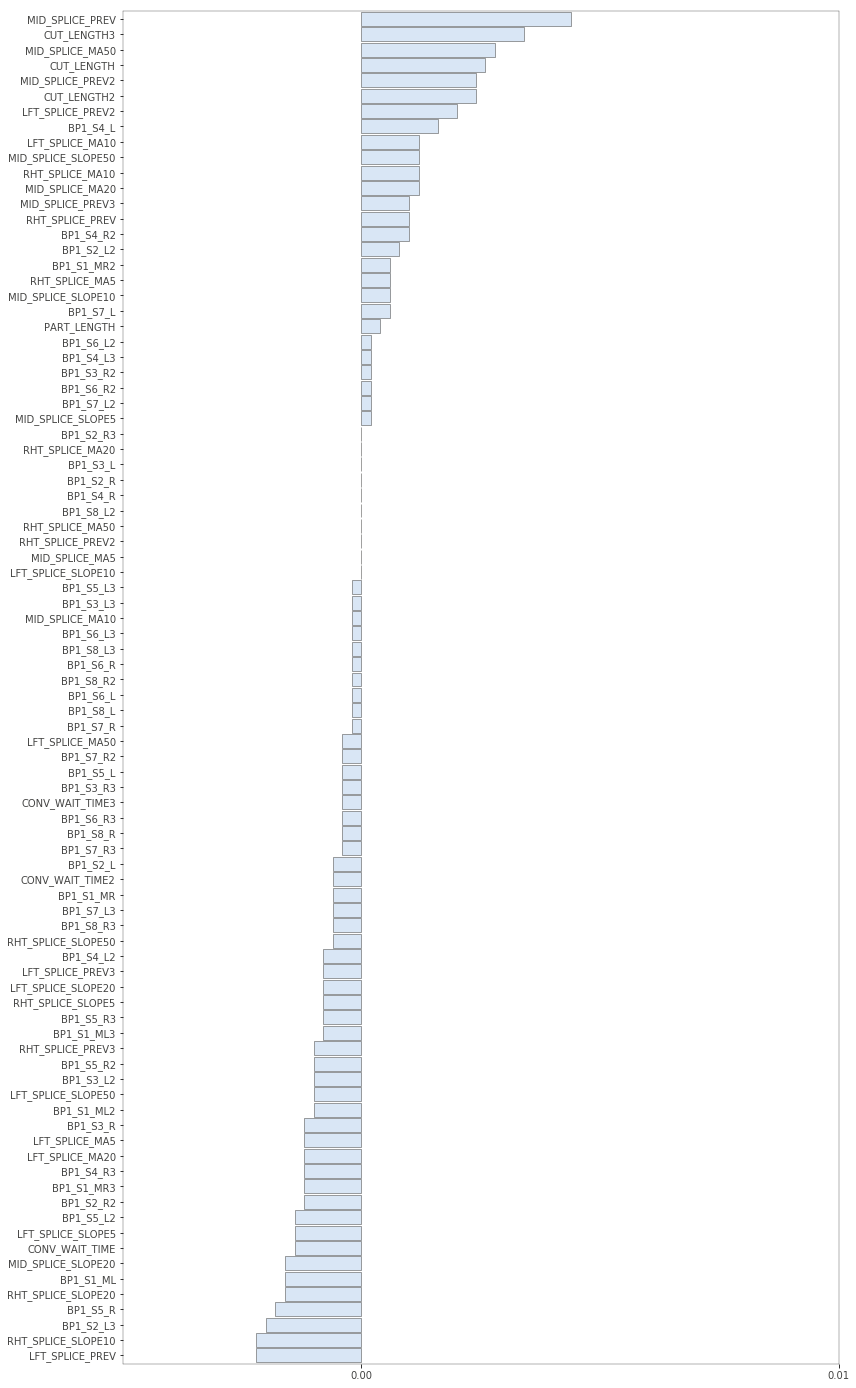

-- took  87.41261768341064  seconds
RandomForestClassifier Accuracy : 0.8452526961302601


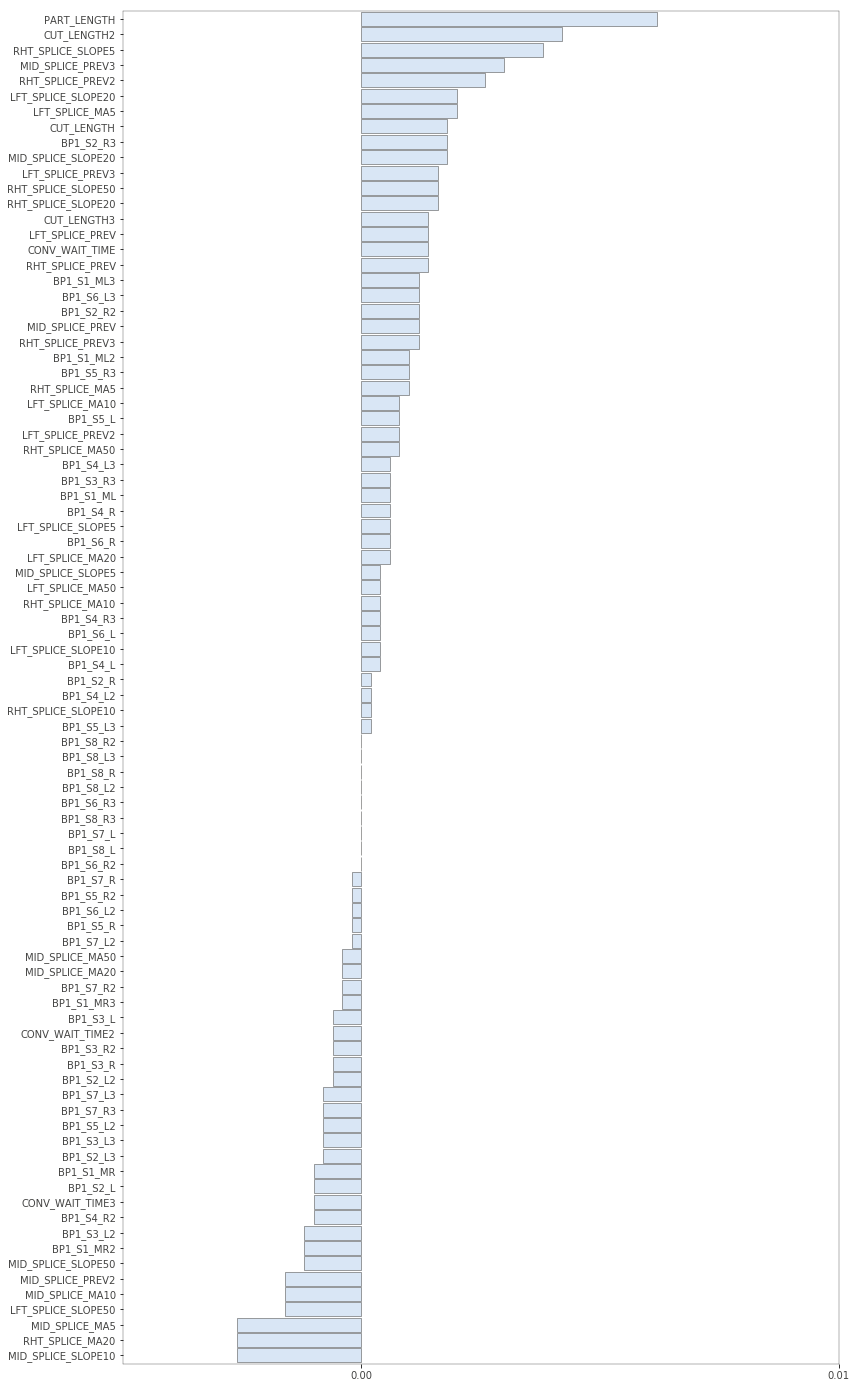

-- took  114.52381563186646  seconds
XGBClassifier Accuracy : 0.8481285684076972


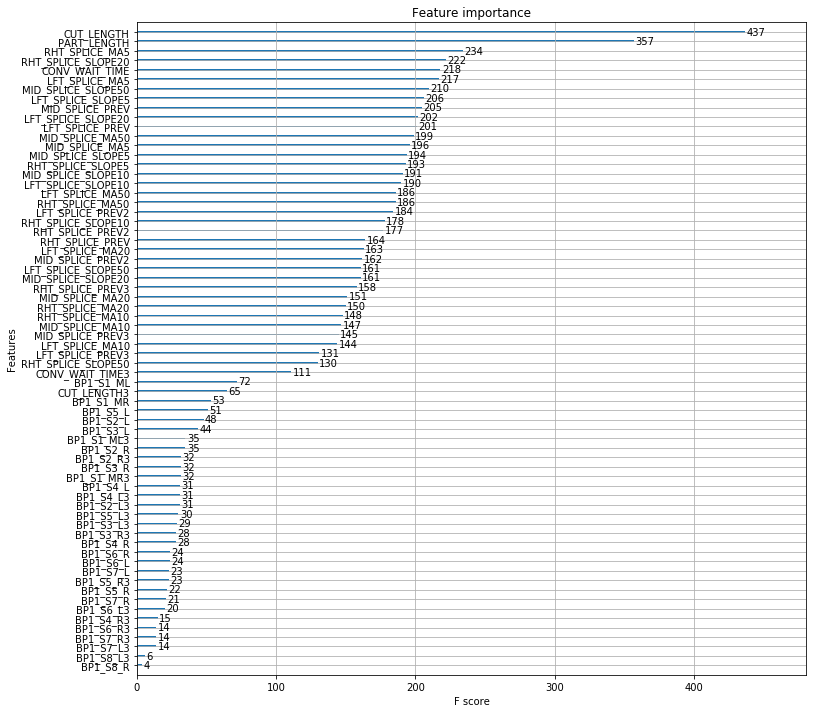

-- took  479.48948764801025  seconds
 ********** FOLD -  2  ********** 
ExtraTreesClassifier Accuracy : 0.8451192691591948


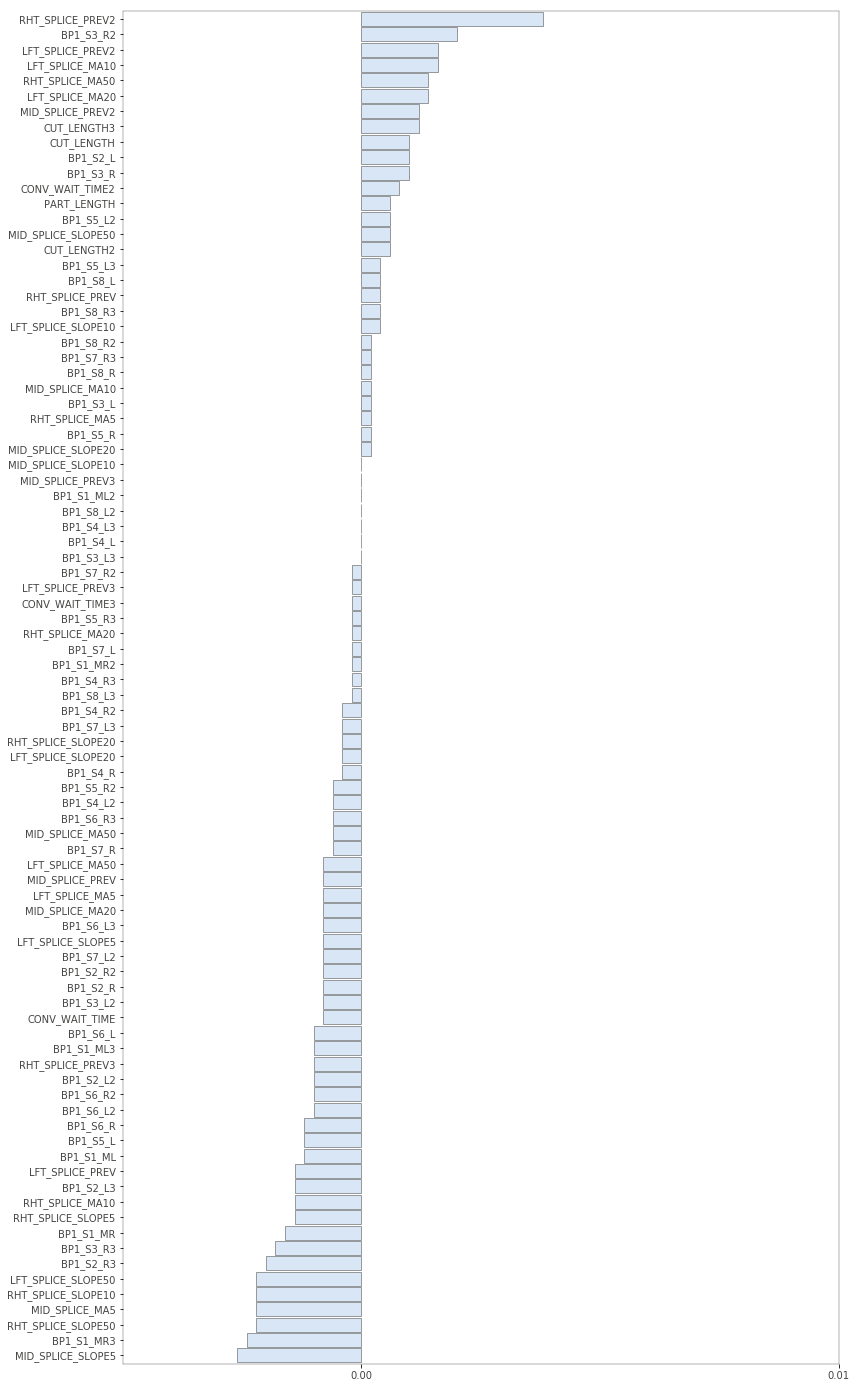

-- took  69.6330943107605  seconds
RandomForestClassifier Accuracy : 0.8488834376586026


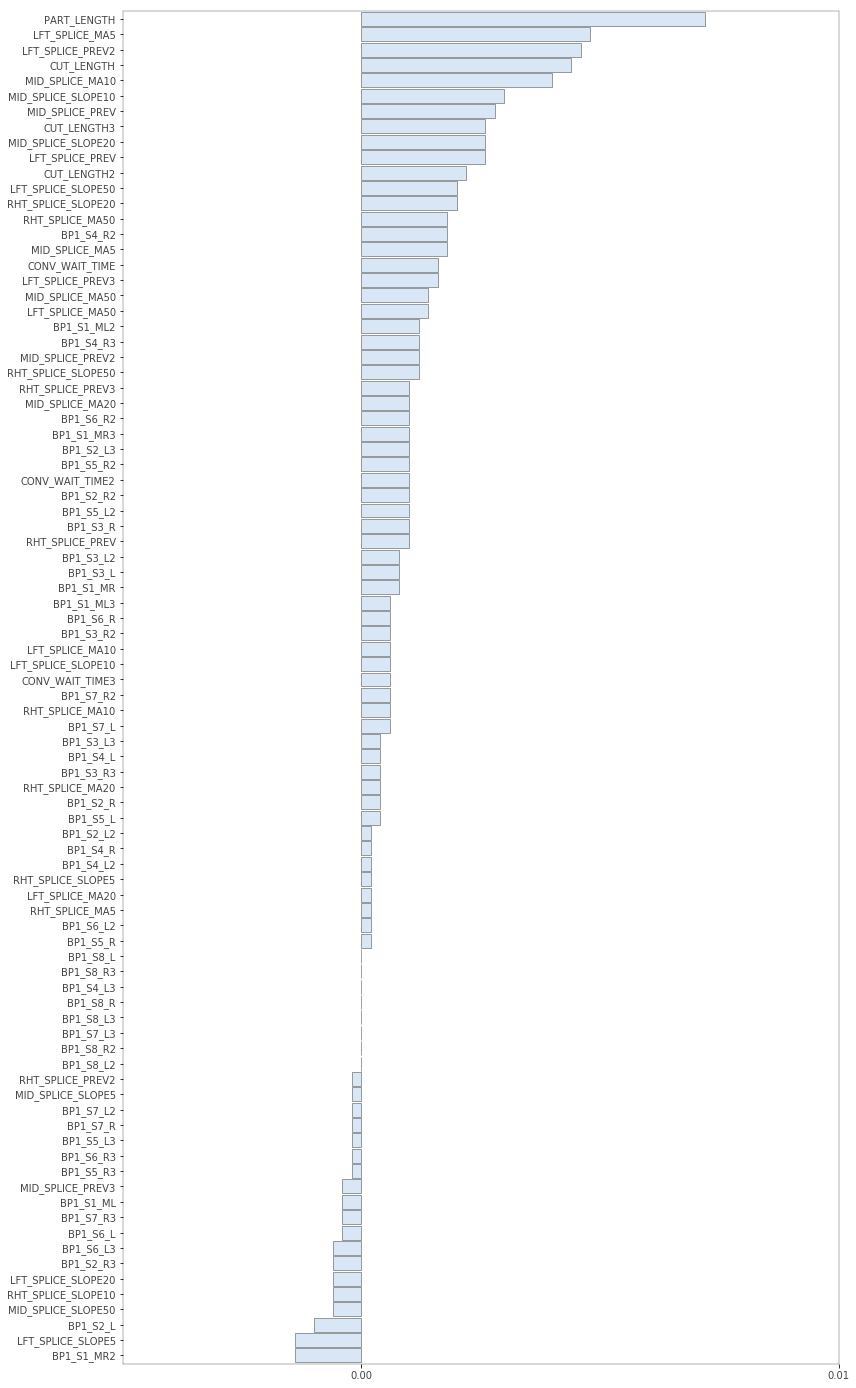

-- took  113.323002576828  seconds
XGBClassifier Accuracy : 0.8485450854339367


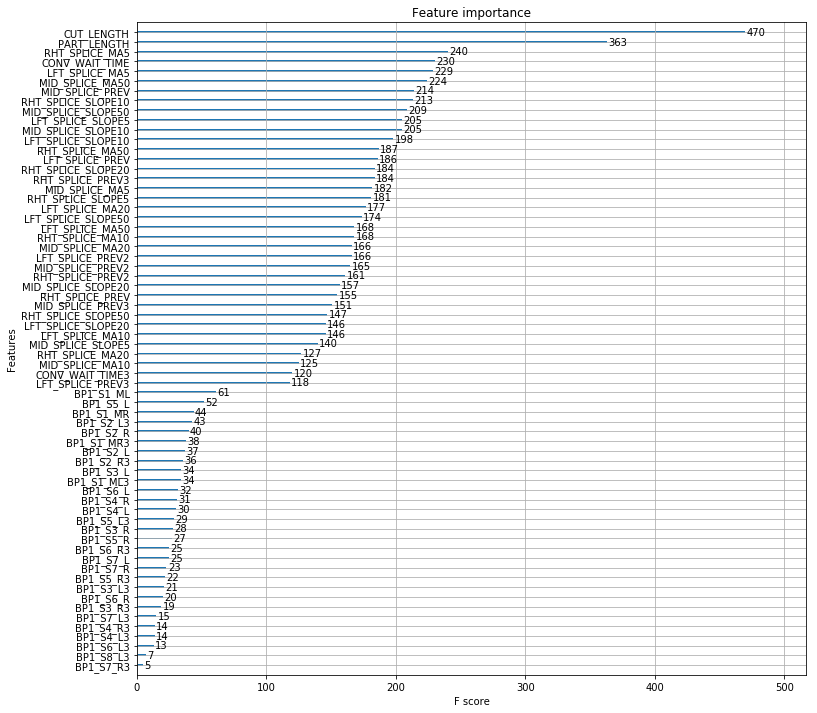

-- took  517.0957119464874  seconds
 ********** FOLD -  3  ********** 
ExtraTreesClassifier Accuracy : 0.8474877347318559


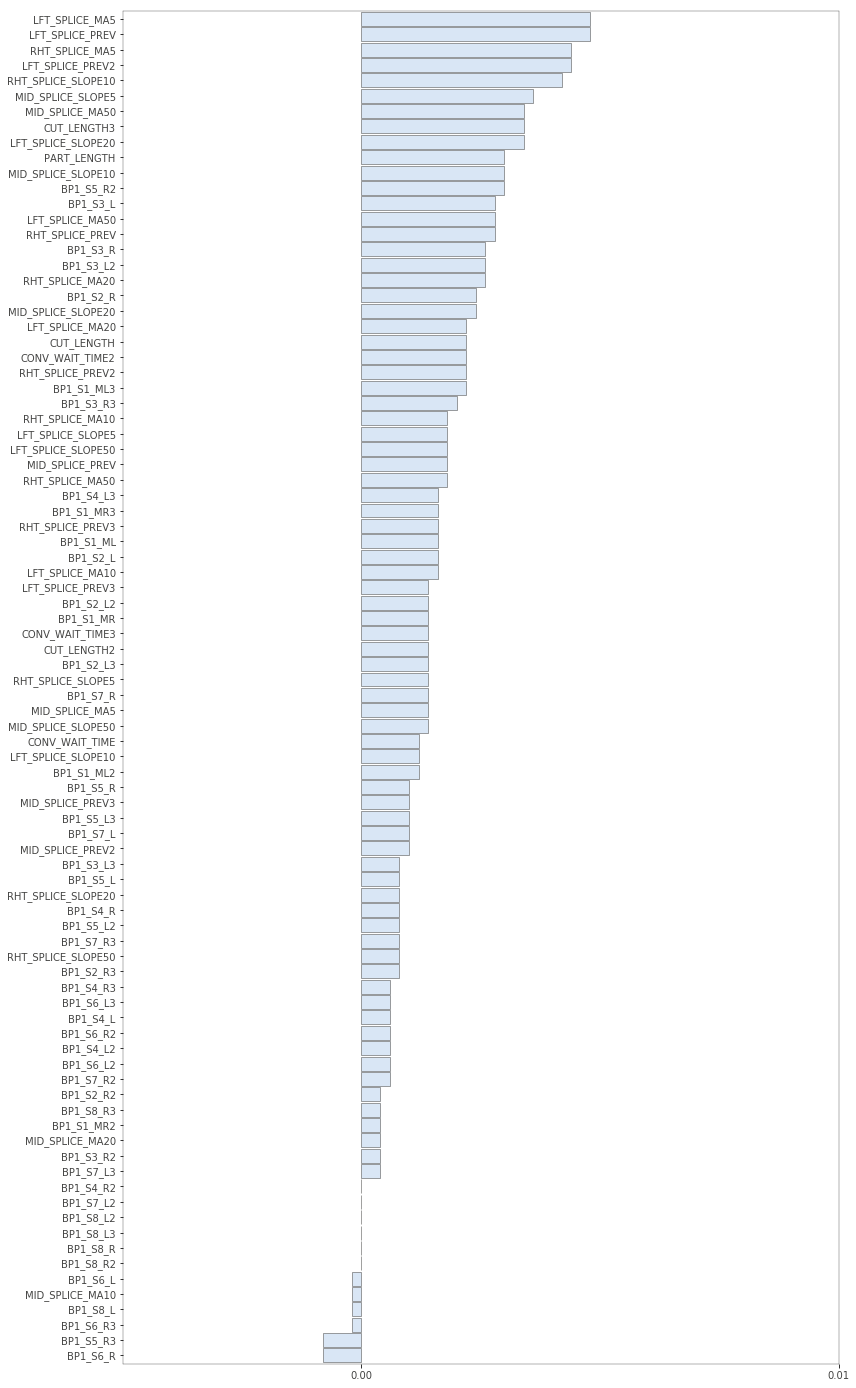

-- took  69.90086817741394  seconds
RandomForestClassifier Accuracy : 0.8492640839113517


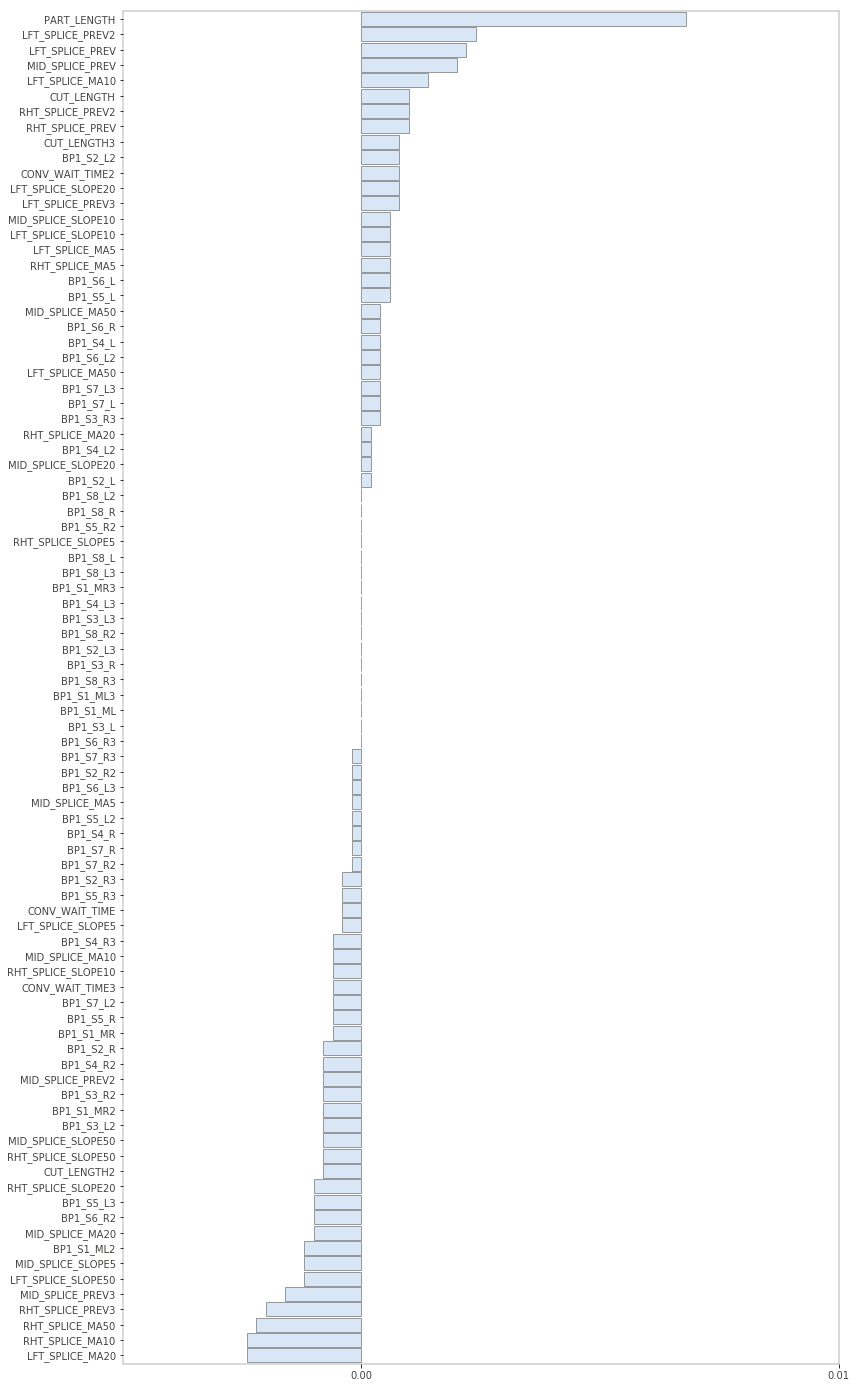

-- took  118.19267725944519  seconds
XGBClassifier Accuracy : 0.8520131957367619


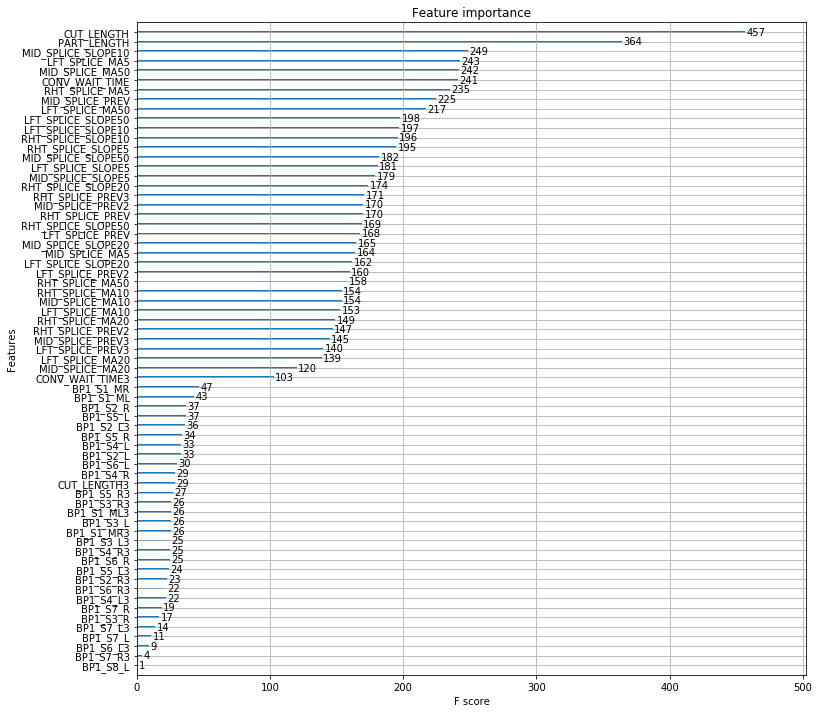

-- took  647.0182456970215  seconds
 ********** FOLD -  4  ********** 
ExtraTreesClassifier Accuracy : 0.845112718352155


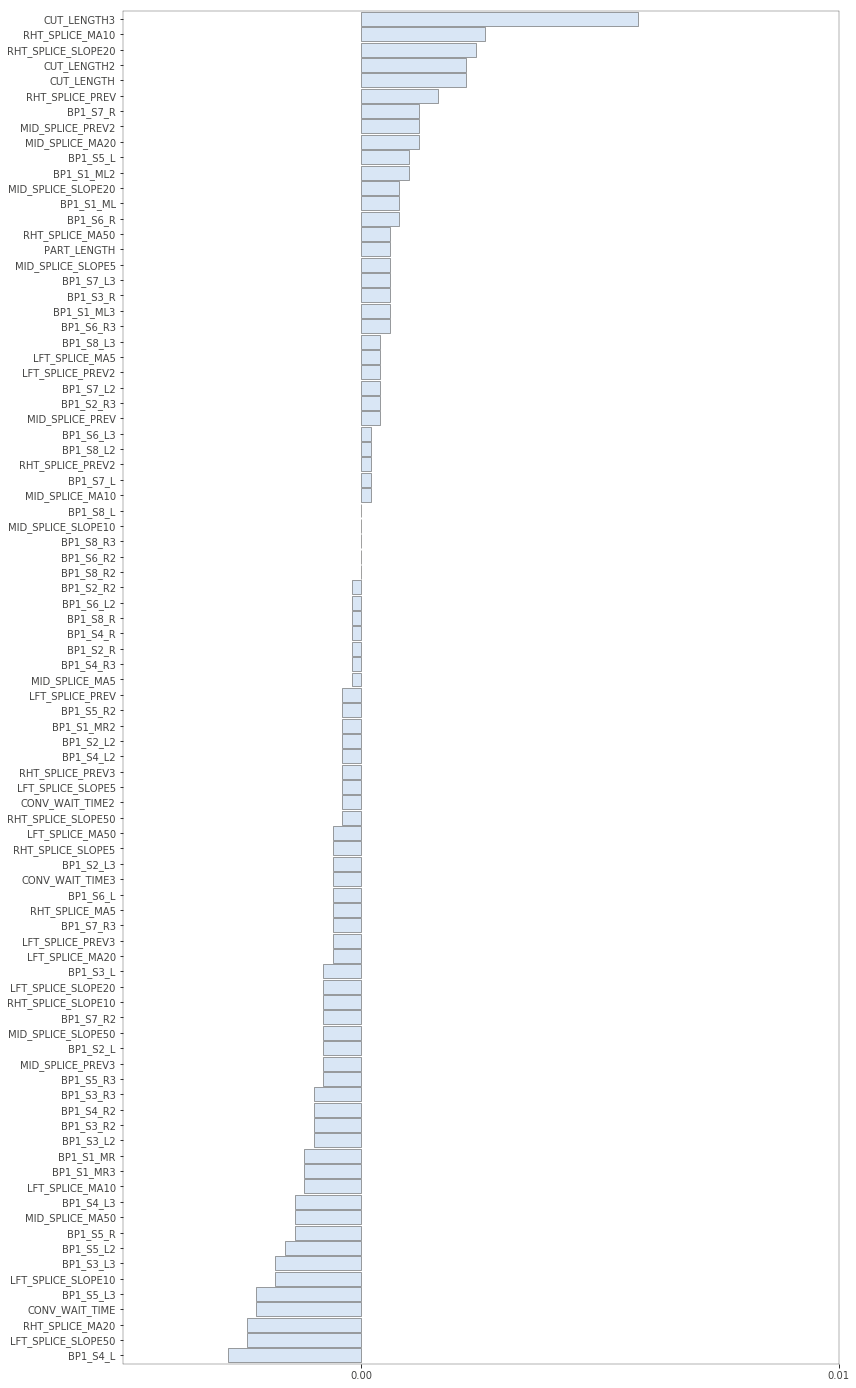

-- took  64.38457679748535  seconds
RandomForestClassifier Accuracy : 0.8504842871040054


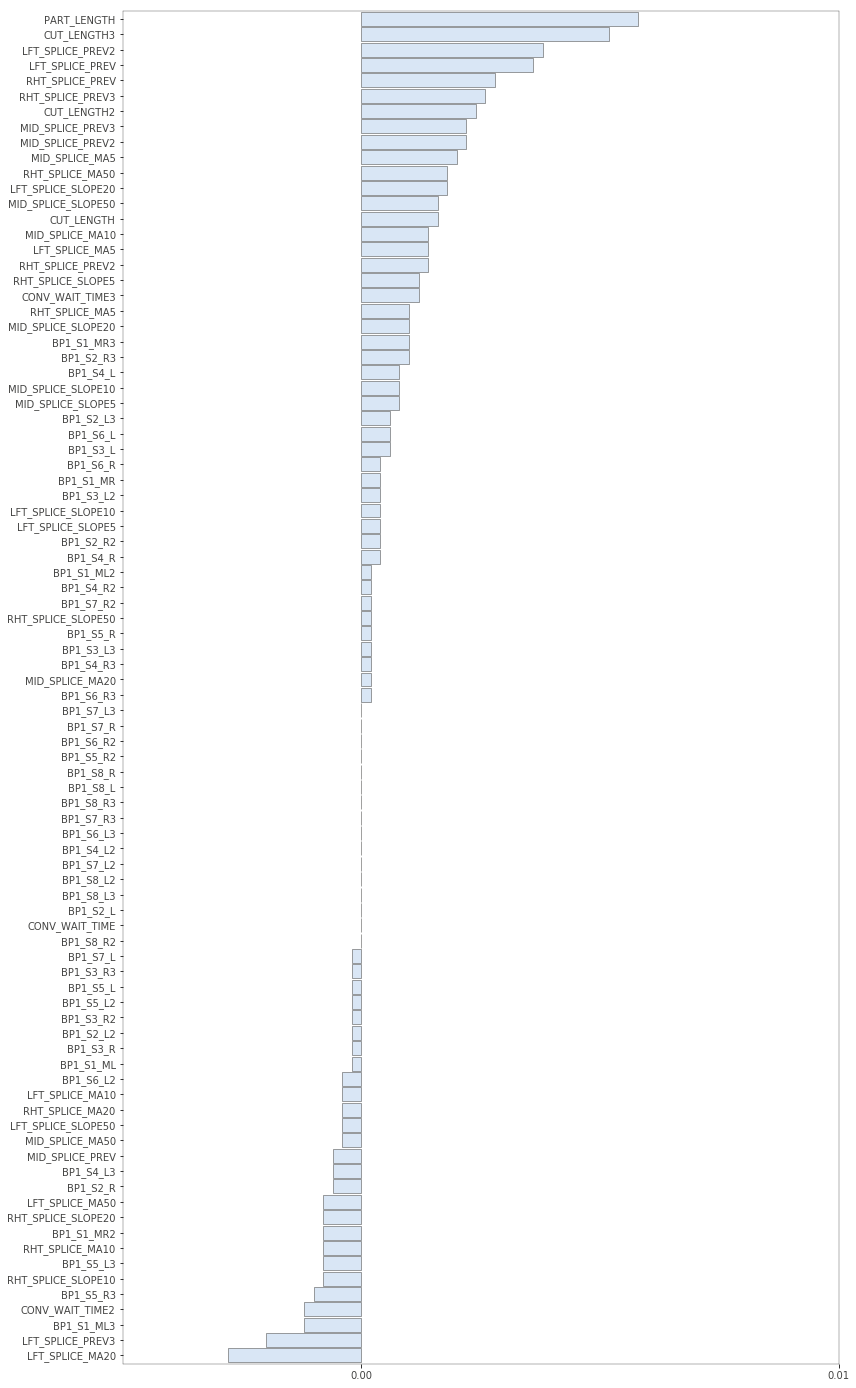

-- took  133.84993624687195  seconds
XGBClassifier Accuracy : 0.8503151038362305


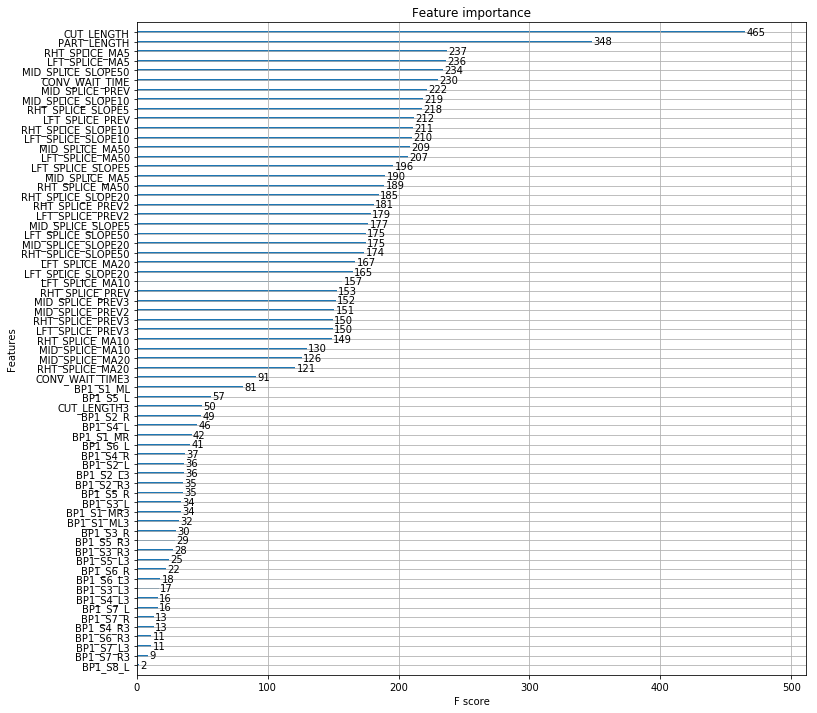

-- took  625.0534250736237  seconds
 ********** FOLD -  5  ********** 
ExtraTreesClassifier Accuracy : 0.8444359852810557


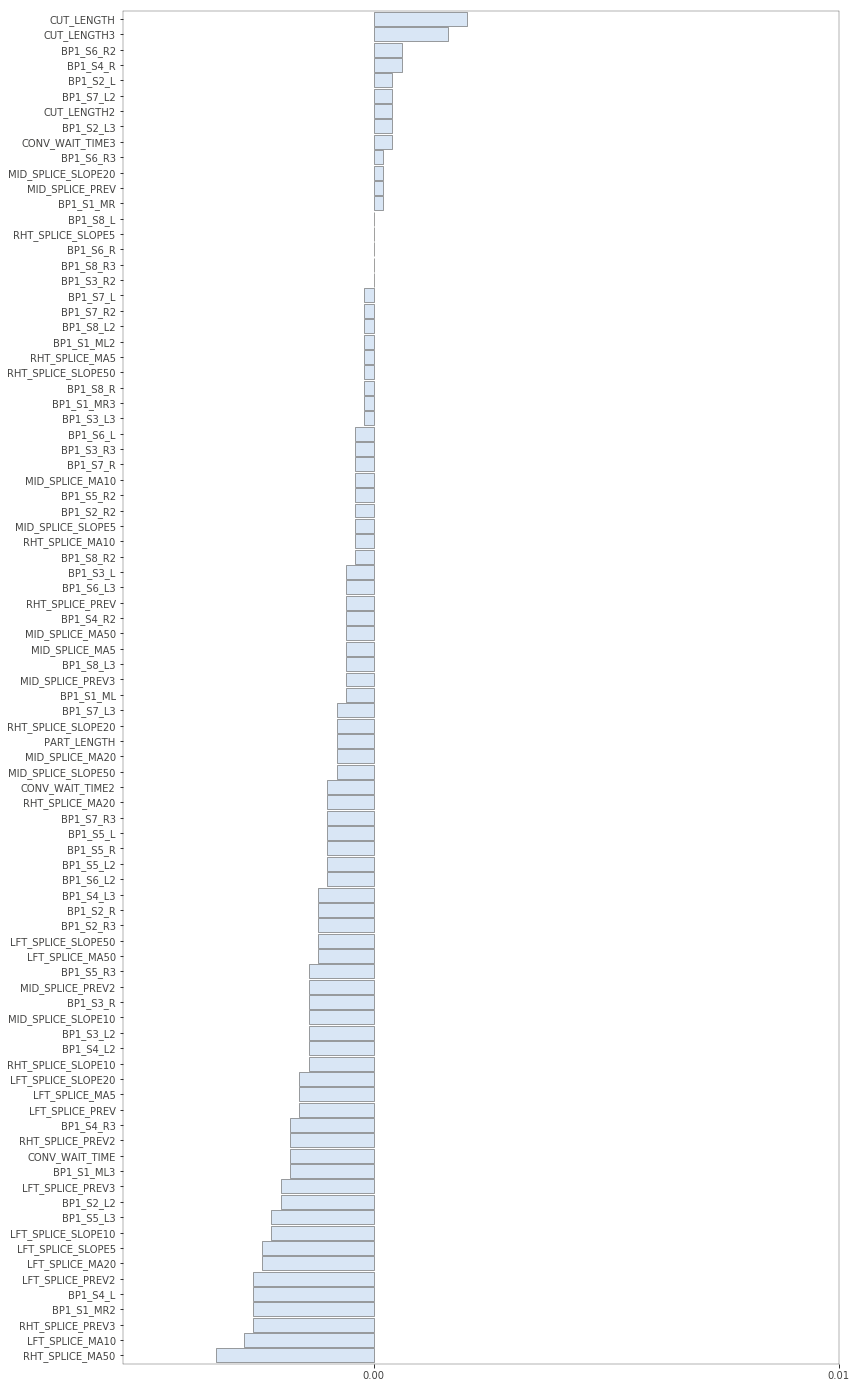

-- took  67.34768629074097  seconds
RandomForestClassifier Accuracy : 0.8490039335109758


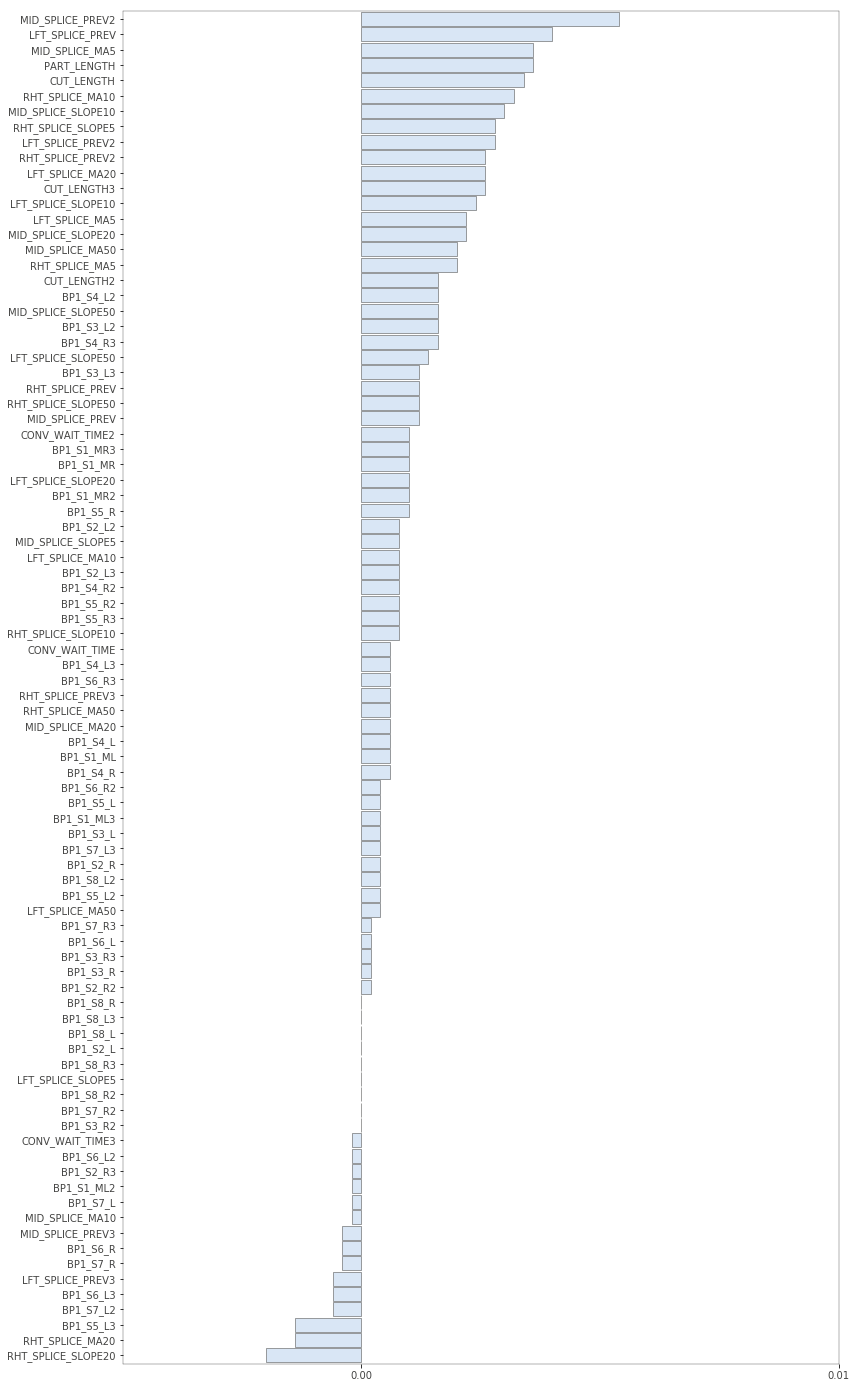

-- took  115.94750785827637  seconds
XGBClassifier Accuracy : 0.8509495410903861


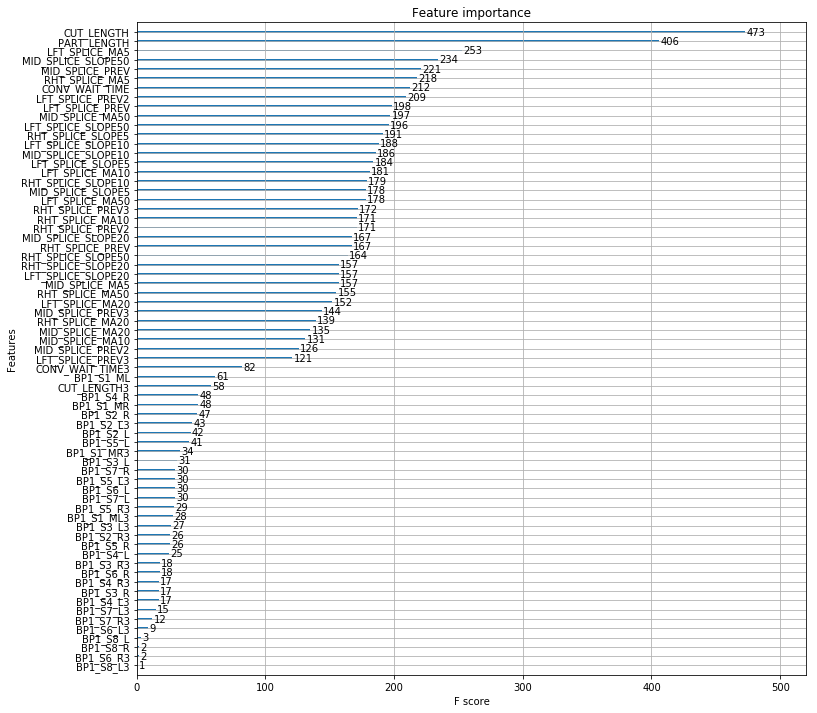

-- took  515.9112422466278  seconds


In [12]:
X = df.drop(['SPLICE_GRADE'], axis=1)
y = df['SPLICE_GRADE']
y = y.astype('int')

# fig, ax = plt.subplots(figsize=(12, 12))

fold = 1
# kf = KFold(n_splits=10, random_state=7, shuffle=True)
kf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

for train_index, test_index in kf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x1, x2 = X.iloc[train_index], X.iloc[test_index]
    y1, y2 = y.iloc[train_index], y.iloc[test_index]
    
    print(" ********** FOLD - ", fold, " ********** ")
    # Train our classifier and test predict
#     BNB.fit(x1,y1)
#     y2_BNB_model = BNB.predict(x2)
#     print("BernoulliNB Accuracy :", accuracy_score(y2, y2_BNB_model))

#     GNB.fit(x1, y1)
#     y2_GNB_model = GNB.predict(x2)
#     print("GaussianNB Accuracy :", accuracy_score(y2, y2_GNB_model))

    KNN.fit(x1,y1)
    y2_KNN_model = KNN.predict(x2)
    print("KNeighborsClassifier Accuracy :", accuracy_score(y2, y2_KNN_model))

    LR.fit(x1,y1)
    y2_LR_model = LR.predict(x2)
    print("LogisticRegression Accuracy :", accuracy_score(y2, y2_LR_model))

#     LSVC.fit(x1,y1)
#     y2_LSVC_model = LSVC.predict(x2)
#     print("LinearSVC Accuracy :", accuracy_score(y2, y2_LSVC_model))

    MLP1.fit(x1,y1)
    y2_MLP1_model = MLP1.predict(x2)
    print("MLPClassifier 1 Accuracy :", accuracy_score(y2, y2_MLP1_model))
    
#     MLP2.fit(x1,y1)
#     y2_MLP2_model = MLP2.predict(x2)
#     print("MLPClassifier 2 Accuracy :", accuracy_score(y2, y2_MLP2_model))
    
# #     MNB.fit(x1,y1)
# #     y2_MNB_model = MNB.predict(x2)
# #     print("MultinomialNB Accuracy :", accuracy_score(y2, y2_MNB_model))
    
# #     NSVC.fit(x1,y1)
# #     y2_NSVC_model = NSVC.predict(x2)
# #     print("NuSVC Accuracy :", accuracy_score(y2, y2_NSVC_model))
    
#     SGD.fit(x1,y1)
#     y2_SGD_model = SGD.predict(x2)
#     print("SGDClassifier Accuracy :", accuracy_score(y2, y2_SGD_model))
    
#     SVC.fit(x1,y1)
#     y2_SVC_model = SVC.predict(x2)
#     print("SVC Accuracy :", accuracy_score(y2, y2_SVC_model))
    
    ADA.fit(x1,y1)
    y2_ADA_model = ADA.predict(x2)
    print("AdaBoostClassifier Accuracy :", accuracy_score(y2, y2_ADA_model))
    
    
    time1 = time.time()  
    BAG.fit(x1,y1)
    y2_BAG_model = BAG.predict(x2)
    print("BaggingClassifier Accuracy :", accuracy_score(y2, y2_BAG_model))
    time2 = time.time()
    print("-- took ", time2 - time1, " seconds")

    time1 = time.time()  
    XTree.fit(x1,y1)
    y2_XTree_model = XTree.predict(x2)
    print("ExtraTreesClassifier Accuracy :", accuracy_score(y2, y2_XTree_model))
    imp = importances(XTree, x2, y2)
    viz = plot_importances(imp, width=12, imp_range=(-0.005, 0.01))
    viz.view()
    time2 = time.time()
    print("-- took ", time2 - time1, " seconds")

    time1 = time.time()  
    GBC.fit(x1,y1)
    y2_GBC_model = GBC.predict(x2)
    print("GradientBoostingClassifier Accuracy :", accuracy_score(y2, y2_GBC_model))
    time2 = time.time()
    print("-- took ", time2 - time1, " seconds")

    time1 = time.time()  
    RFC.fit(x1,y1)
    y2_RFC_model = RFC.predict(x2)
    print("RandomForestClassifier Accuracy :", accuracy_score(y2, y2_RFC_model))
    imp = importances(RFC, x2, y2)
    viz = plot_importances(imp, width=12, imp_range=(-0.005, 0.01))
    viz.view()
    time2 = time.time()
    print("-- took ", time2 - time1, " seconds")
    
    time1 = time.time()  
    XGB.fit(x1,y1)
    y2_XGB_model = XGB.predict(x2)
    print("XGBClassifier Accuracy :", accuracy_score(y2, y2_XGB_model))
    ax = plot_importance(XGB) # , ax=ax)
    fig = ax.figure
    fig.set_size_inches(15,12)
    plt.show()
    time2 = time.time()
    print("-- took ", time2 - time1, " seconds")
    
    fold += 1


In [13]:
# target_names = ['Bad', 'OK', 'Good']
target_names = ['Bad', 'Good']
class_names = target_names

In [14]:
# print(" *********** BernoulliNB *********** ")
# print(classification_report(y2, y2_BNB_model, target_names=target_names, sample_weight=None, digits=4))

# print(" *********** GaussianNB *********** ")
# print(classification_report(y2, y2_GNB_model, target_names=target_names, sample_weight=None, digits=4))

# print(" *********** KNeighborsClassifier *********** ")
# print(classification_report(y2, y2_KNN_model, target_names=target_names, sample_weight=None, digits=4))

# print(" *********** LogisticRegression *********** ")
# print(classification_report(y2, y2_LR_model, target_names=target_names, sample_weight=None, digits=4))

# print(" *********** LinearSVC *********** ")
# print(classification_report(y2, y2_LSVC_model, target_names=target_names, sample_weight=None, digits=4))

# print(" *********** MLPClassifier 1 *********** ")
# print(classification_report(y2, y2_MLP1_model, target_names=target_names, sample_weight=None, digits=4))

# print(" *********** MLPClassifier 2 *********** ")
# print(classification_report(y2, y2_MLP2_model, target_names=target_names, sample_weight=None, digits=4))

# print(" *********** SGDClassifier *********** ")
# print(classification_report(y2, y2_SGD_model, target_names=target_names, sample_weight=None, digits=4))

# print(" *********** SVC *********** ")
# print(classification_report(y2, y2_SVC_model, target_names=target_names, sample_weight=None, digits=4))

# print(" *********** AdaBoostClassifier *********** ")
# print(classification_report(y2, y2_ADA_model, target_names=target_names, sample_weight=None, digits=4))
    
# print(" *********** BaggingClassifier *********** ")
# print(classification_report(y2, y2_BAG_model, target_names=target_names, sample_weight=None, digits=4))

print(" *********** ExtraTreesClassifier *********** ")
print(classification_report(y2, y2_XTree_model, target_names=target_names, sample_weight=None, digits=4))

# print(" *********** GradientBoostingClassifier *********** ")
# print(classification_report(y2, y2_GBC_model, target_names=target_names, sample_weight=None, digits=4))

print(" *********** RandomForestClassifier *********** ")
print(classification_report(y2, y2_RFC_model, target_names=target_names, sample_weight=None, digits=4))

print(" *********** XGBClassifier *********** ")
print(classification_report(y2, y2_XGB_model, target_names=target_names, sample_weight=None, digits=4))


 *********** ExtraTreesClassifier *********** 
              precision    recall  f1-score   support

         Bad     0.6519    0.3253    0.4340      4335
        Good     0.8638    0.9610    0.9098     19308

   micro avg     0.8444    0.8444    0.8444     23643
   macro avg     0.7578    0.6431    0.6719     23643
weighted avg     0.8250    0.8444    0.8226     23643

 *********** RandomForestClassifier *********** 
              precision    recall  f1-score   support

         Bad     0.6616    0.3612    0.4673      4335
        Good     0.8699    0.9585    0.9120     19308

   micro avg     0.8490    0.8490    0.8490     23643
   macro avg     0.7657    0.6599    0.6897     23643
weighted avg     0.8317    0.8490    0.8305     23643

 *********** XGBClassifier *********** 
              precision    recall  f1-score   support

         Bad     0.6619    0.3825    0.4848      4335
        Good     0.8734    0.9561    0.9129     19308

   micro avg     0.8509    0.8509    0.8509   

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in it.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y2, y2_BAG_model)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='BAG Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='BAG Normalized confusion matrix')

# plt.show();

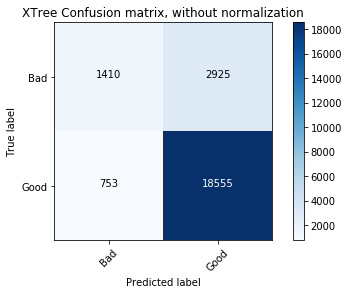

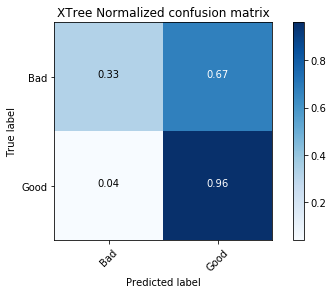

In [17]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y2, y2_XTree_model)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='XTree Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='XTree Normalized confusion matrix')

plt.show();

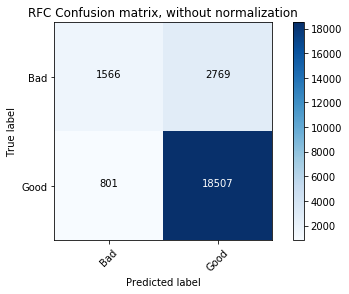

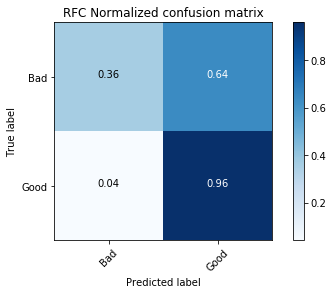

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y2, y2_RFC_model)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='RFC Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='RFC Normalized confusion matrix')

plt.show();

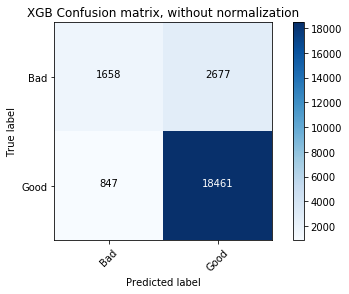

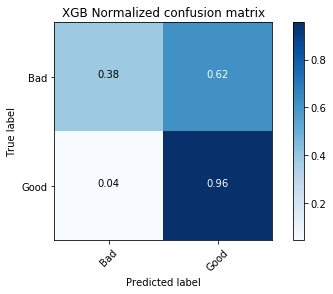

In [19]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y2, y2_XGB_model)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='XGB Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='XGB Normalized confusion matrix')

plt.show();

In [20]:
# Try out these
# sklearn.multioutput.MultiOutputClassifier
# sklearn.multiclass.OutputCodeClassifier
# sklearn.multiclass.OneVsOneClassifier
# sklearn.multiclass.OneVsRestClassifier
# sklearn.model_selection.RandomizedSearchCV -- https://stackoverflow.com/questions/52029408/sklearn-mlp-classifier-hyperparameter-optimization-randomizedsearchcv
# sklearn.model_selection.check_cv
# sklearn.model_selection.StratifiedKFold
# sklearn.linear_model.RidgeClassifierCV
# sklearn.linear_model.PassiveAggressiveClassifier
# sklearn.linear_model.LogisticRegressionCV
# sklearn.gaussian_process.GaussianProcessClassifier
# sklearn.tree.DecisionTreeClassifier
# sklearn.tree.ExtraTreeClassifier
# Feature significance
# Narrow to Wide Splice
# Prev Deltas MA & Slope
